In [1]:
import cv2
import os
import numpy as np

# Input paths
input_base_path = r"C:\Users\creat\Downloads\combined_dataset\"
real_videos_path = os.path.join(input_base_path, "real")
fake_videos_path = os.path.join(input_base_path, "fake")

# Output paths
output_base_path = r"C:\Users\creat\Downloads\FramesExtracted"
real_output_path = os.path.join(output_base_path, "RealFrames")
fake_output_path = os.path.join(output_base_path, "FakeFrames")

# Create output directories if they don't exist
os.makedirs(real_output_path, exist_ok=True)
os.makedirs(fake_output_path, exist_ok=True)

def extract_frames(video_path, output_folder, video_name, num_frames=30):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < num_frames:
        print(f"Skipping {video_name}: Not enough frames.")
        cap.release()
        return

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    saved = 0
    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_indices:
            frame_filename = f"{video_name}_frame{saved+1:02d}.jpg"
            frame_path = os.path.join(output_folder, frame_filename)
            cv2.imwrite(frame_path, frame)
            saved += 1
    cap.release()

# Process real videos
print("Processing real videos...")
for video_file in os.listdir(real_videos_path):
    if video_file.endswith(".mp4"):
        video_path = os.path.join(real_videos_path, video_file)
        video_name = os.path.splitext(video_file)[0]
        extract_frames(video_path, real_output_path, video_name)

# Process fake videos, but only 590 of them
print("Processing fake videos (limit: 1090 videos)...")
fake_video_count = 0
fake_video_limit = 1090

for video_file in os.listdir(fake_videos_path):
    if fake_video_count >= fake_video_limit:
        break
    if video_file.endswith(".mp4"):
        video_path = os.path.join(fake_videos_path, video_file)
        video_name = os.path.splitext(video_file)[0]
        extract_frames(video_path, fake_output_path, video_name)
        fake_video_count += 1

print("Done extracting frames.")


Processing real videos...
Skipping id27_0005: Not enough frames.
Processing fake videos (limit: 590 videos)...
Done extracting frames.


In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

# Define paths
input_base_path = r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\BothDatasets\FramesExtracted"
output_base_path = r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\BothDatasets\ModelTrainingDataset"

real_frames_path = os.path.join(input_base_path, "RealFrames")
fake_frames_path = os.path.join(input_base_path, "FakeFrames")

splits = ['train', 'val', 'test']
categories = ['Real', 'Fake']

# Create folder structure
for split in splits:
    for category in categories:
        os.makedirs(os.path.join(output_base_path, split, category), exist_ok=True)

# --- Utility: Extract video ID from any forensic frame filename ---
def extract_video_id(filename):
    # For filenames like "id_0000_frame01.jpg" or "id_0001_frame30.jpg"
    # We want to extract "id_0000" or "id_0001"
    parts = filename.split('_')
    if len(parts) >= 3 and parts[0] == 'id' and parts[2].startswith('frame'):
        return f"{parts[0]}_{parts[1]}"
    # Fallback for other naming patterns if any
    return filename.split('_frame')[0] if '_frame' in filename else filename.split('.')[0]

# --- Group frames by their video ID ---
def group_frames_by_video(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    grouped = defaultdict(list)
    for f in files:
        video_id = extract_video_id(f)
        grouped[video_id].append(f)
    return grouped

# --- Split and move videos safely ---
def split_and_move(grouped, source_dir, target_dirs, val_size=0.2, test_size=0.1, desc_prefix=""):
    video_ids = list(grouped.keys())

    # Drop one if odd to keep balancing clean
    if len(video_ids) % 2 != 0:
        video_ids = video_ids[:-1]

    # Split video groups
    train_ids, temp_ids = train_test_split(video_ids, test_size=(val_size + test_size), random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=(test_size / (val_size + test_size)), random_state=42)

    def move(video_ids, dest_dir, desc):
        for vid in tqdm(video_ids, desc=f"{desc_prefix} - {desc}", unit="video"):
            for frame in grouped[vid]:
                src_path = os.path.join(source_dir, frame)
                dest_path = os.path.join(dest_dir, frame)
                if os.path.exists(src_path):
                    shutil.move(src_path, dest_path)
                else:
                    print(f"Warning: File not found - {src_path}")

    move(train_ids, target_dirs["train"], "Train")
    move(val_ids, target_dirs["val"], "Validation")
    move(test_ids, target_dirs["test"], "Test")

# --- Process Real ---
print("Processing Real frames...")
real_groups = group_frames_by_video(real_frames_path)
split_and_move(
    real_groups,
    real_frames_path,
    {
        "train": os.path.join(output_base_path, "train", "Real"),
        "val": os.path.join(output_base_path, "val", "Real"),
        "test": os.path.join(output_base_path, "test", "Real"),
    },
    desc_prefix="Real"
)

# --- Process Fake ---
print("Processing Fake frames...")
fake_groups = group_frames_by_video(fake_frames_path)
split_and_move(
    fake_groups,
    fake_frames_path,
    {
        "train": os.path.join(output_base_path, "train", "Fake"),
        "val": os.path.join(output_base_path, "val", "Fake"),
        "test": os.path.join(output_base_path, "test", "Fake"),
    },
    desc_prefix="Fake"
)

print("\n✅ All frames split by video ID with NO data leakage and moved successfully!")

Processing Real frames...


Real - Test: 100%|████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 29.39video/s]


Processing Fake frames...


Fake - Test: 100%|████████████████████████████████████████████████████████████████| 110/110 [00:03<00:00, 33.47video/s]


✅ All frames split by video ID with NO data leakage and moved successfully!


In [16]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Initialize face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Define paths
original_base_path = r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\Data_for_deepfake\AdvanceDatasetForModelTraining"
new_base_path = r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\Data_for_deepfake\FaceDataset"

# Create new directory structure
for split in ['training', 'testing', 'validation']:
    for category in ['Real', 'Fake']:
        os.makedirs(os.path.join(new_base_path, split, category), exist_ok=True)

# Map original splits to new splits (train->training, val->validation, test->testing)
split_mapping = {
    'train': 'training',
    'val': 'validation',
    'test': 'testing'
}

def detect_and_save_faces(input_path, output_path):
    """Detect faces in an image and save the cropped face"""
    img = cv2.imread(input_path)
    if img is None:
        print(f"Warning: Could not read image {input_path}")
        return
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    if len(faces) == 0:
        # If no face detected, save the entire image as fallback
        cv2.imwrite(output_path, img)
        return
    
    # Get the largest face (assuming it's the main subject)
    faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)
    x, y, w, h = faces[0]
    
    # Add some padding around the face
    padding = int(w * 0.2)
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(img.shape[1] - x, w + 2*padding)
    h = min(img.shape[0] - y, h + 2*padding)
    
    face_img = img[y:y+h, x:x+w]
    cv2.imwrite(output_path, face_img)

def process_dataset():
    for original_split, new_split in split_mapping.items():
        for category in ['Real', 'Fake']:
            input_dir = os.path.join(original_base_path, original_split, category)
            output_dir = os.path.join(new_base_path, new_split, category)
            
            print(f"Processing {original_split}/{category} -> {new_split}/{category}")
            
            if not os.path.exists(input_dir):
                print(f"Directory not found: {input_dir}")
                continue
                
            frame_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for frame_file in tqdm(frame_files, desc=f"{new_split}/{category}"):
                input_path = os.path.join(input_dir, frame_file)
                output_path = os.path.join(output_dir, frame_file)
                detect_and_save_faces(input_path, output_path)

if __name__ == "__main__":
    process_dataset()
    print("\n✅ Face extraction completed successfully!")

Processing train/Real -> training/Real


training/Real: 100%|█████████████████████████████████████████████████████████████| 22830/22830 [12:11<00:00, 31.20it/s]


Processing train/Fake -> training/Fake


training/Fake: 100%|█████████████████████████████████████████████████████████████| 22830/22830 [11:09<00:00, 34.09it/s]


Processing val/Real -> validation/Real


validation/Real: 100%|█████████████████████████████████████████████████████████████| 6540/6540 [03:45<00:00, 28.95it/s]


Processing val/Fake -> validation/Fake


validation/Fake: 100%|█████████████████████████████████████████████████████████████| 6540/6540 [03:01<00:00, 36.08it/s]


Processing test/Real -> testing/Real


testing/Real: 100%|████████████████████████████████████████████████████████████████| 3270/3270 [01:45<00:00, 31.05it/s]


Processing test/Fake -> testing/Fake


testing/Fake: 100%|████████████████████████████████████████████████████████████████| 3270/3270 [01:27<00:00, 37.49it/s]


✅ Face extraction completed successfully!


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.applications import ResNet50
import os
from sklearn.metrics import roc_curve, roc_auc_score
import cv2
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,MaxPooling2D,Attention,Conv2D,concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import Xception,VGG16,VGG19,MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LeakyReLU
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

train_path= r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\Data_for_deepfake\FaceDataset\training"
test_path=r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\Data_for_deepfake\FaceDataset\testing"
val_path=r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\Data_for_deepfake\FaceDataset\validation"


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

# --- Preprocessing for Xception ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# --- Data Generators with Categorical Labels ---
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'  # Change to categorical for one-hot encoding
)

val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Change to categorical for one-hot encoding
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Change to categorical for one-hot encoding
    shuffle=False  # No shuffle for evaluation
)

Found 45660 images belonging to 2 classes.
Found 13080 images belonging to 2 classes.
Found 6540 images belonging to 2 classes.


In [2]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained Xception base (frozen)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom layers on top of the pre-trained base
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)  # Add dropout
x = Dense(32, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Use softmax for binary classification (2 classes)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [3]:
 
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks for early stopping, model checkpoint, and reduce learning rate
checkpoint = ModelCheckpoint(
    filepath=r'C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\AXceptionSoftmax.h5',  
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

with tf.device('/GPU:1'):
    history = model.fit(
        training_set,                # ✅ your custom training generator
        epochs=30,
        validation_data=val_set, # ✅ your custom validation generator
        callbacks=[early_stopping, checkpoint]
    )


Epoch 1/30
714/714 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.5942
Epoch 1: val_loss improved from inf to 0.62625, saving model to C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\AXceptionSoftmax.h5
714/714 [==============================] - 472s 648ms/step - loss: 0.6653 - accuracy: 0.5942 - val_loss: 0.6262 - val_accuracy: 0.6542
Epoch 2/30
714/714 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.6545
Epoch 2: val_loss improved from 0.62625 to 0.60897, saving model to C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\AXceptionSoftmax.h5
714/714 [==============================] - 461s 646ms/step - loss: 0.6227 - accuracy: 0.6545 - val_loss: 0.6090 - val_accuracy: 0.6714
Epoch 3/30
714/714 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.6739
Epoch 3: val_loss improved from 0.60897 to 0.60030, saving model to C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\A

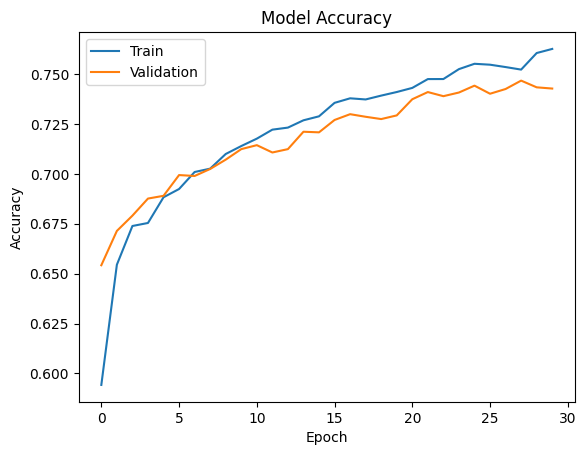

In [4]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

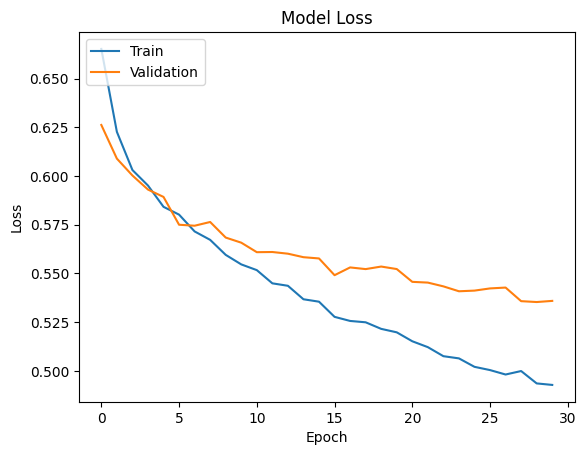

In [5]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [6]:
# Predict the classes using the test set
test_pred = model.predict(test_set)
test_pred_classes = np.round(test_pred)

# Get the true classes of the test set
test_true_classes = test_set.classes

205/205 [==============================] - 38s 183ms/step


205/205 [==============================] - 36s 177ms/step


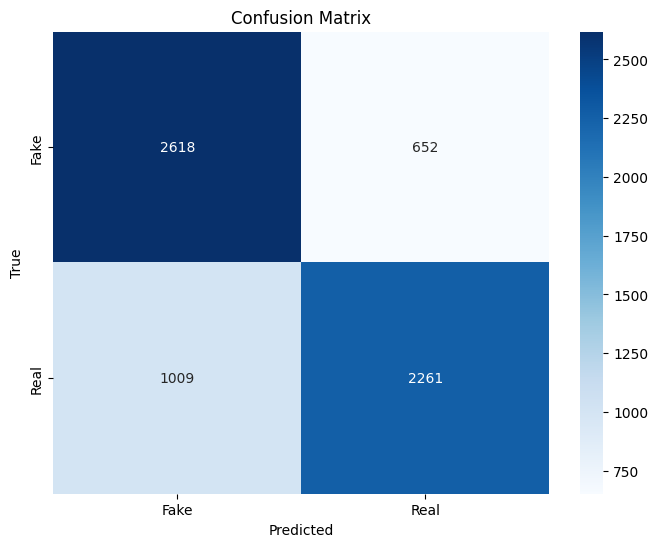

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get class predictions
test_pred = model.predict(test_set)
test_pred_classes = np.argmax(test_pred, axis=1)  # convert probabilities to class labels

# True classes
test_true_classes = test_set.classes  # already in correct format

# Compute confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [8]:
evaluation = model.evaluate(test_set)
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

205/205 [==============================] - 37s 180ms/step - loss: 0.5254 - accuracy: 0.7460
Test Accuracy: 74.60%


In [9]:
#Classification report
report = classification_report(test_true_classes, test_pred_classes, target_names=["Class 0", "Class 1"], labels=[0, 1], digits=4)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0     0.7218    0.8006    0.7592      3270
     Class 1     0.7762    0.6914    0.7314      3270

    accuracy                         0.7460      6540
   macro avg     0.7490    0.7460    0.7453      6540
weighted avg     0.7490    0.7460    0.7453      6540



205/205 [==============================] - 37s 180ms/step


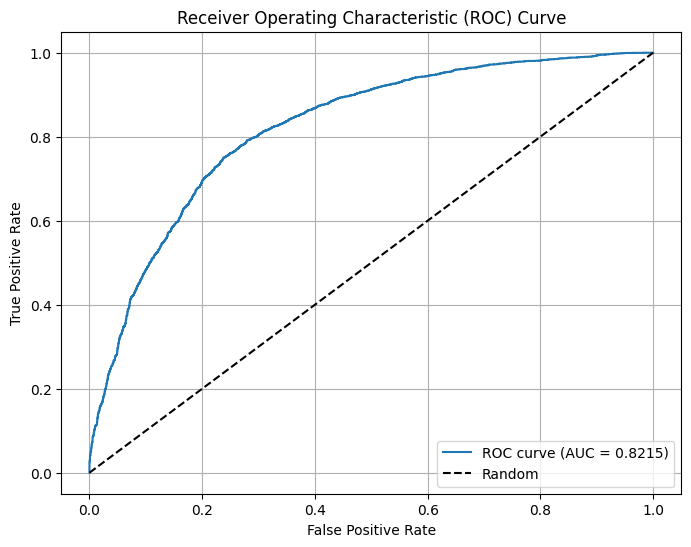

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
test_pred = model.predict(test_set)[:, 1]  # shape: (n_samples,)

# True class labels (0 or 1)
test_true_classes = test_set.classes  # shape: (n_samples,)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_true_classes, test_pred)
auc = roc_auc_score(test_true_classes, test_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



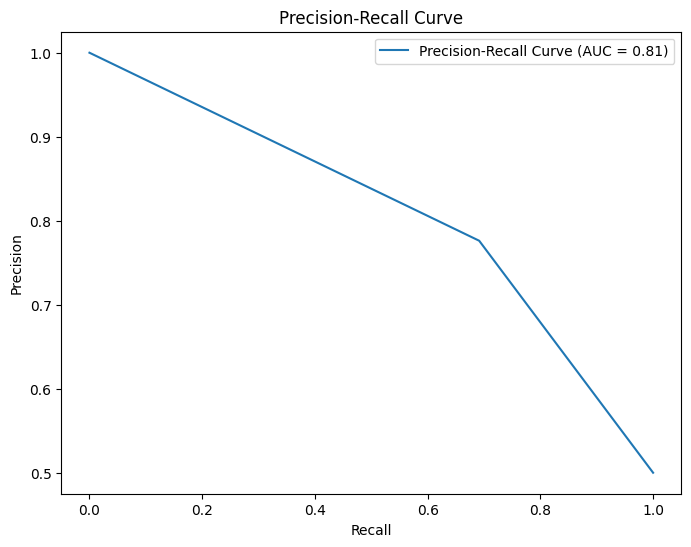

In [11]:

from sklearn.metrics import precision_recall_curve, auc
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(test_true_classes, test_pred_classes)

# Calculate the area under the precision-recall curve (AUC-PR)
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [12]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(test_true_classes, test_pred_classes).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity (True Positive Rate): {sensitivity:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')

Sensitivity (True Positive Rate): 0.6914
Specificity (True Negative Rate): 0.8006
